In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn

from mpc.env_dx import frenet_dyn_bicycle, frenet_kin_bicycle  #changed
from mpc.track.src import simple_track_generator, track_functions

import utils

from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [2]:
def plot_sim(x_simulated,u_simulated, vc=3):
    
    x_list = []
    y_list = []

    color_data = x_simulated[:,vc]
    
    for i in range(x_simulated.shape[0]):
        xy = utils.frenet_to_cartesian(x_simulated[i,:2], track_coord)
        x_list.append(xy[0].numpy())
        y_list.append(xy[1].numpy())
    
    x_plot = np.array(x_list)
    y_plot = np.array(y_list)
    
    fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=250)
    gen.plotPoints(ax)
    
    #custom_cmap = plt.get_cmap('cubehelix').reversed()
    #sct = ax.scatter(x_plot, y_plot, c=color_data, cmap=custom_cmap, s=4)

    custom_cmap = plt.get_cmap('Wistia')#.reversed()
    norm = Normalize(vmin=color_data.min(), vmax=color_data.max())
    sm = ScalarMappable(cmap=custom_cmap, norm=norm)


    for i in range(len(x_plot) - 1):
        ax.plot(x_plot[i:i+2], y_plot[i:i+2], color=custom_cmap(norm(color_data[i])), alpha=0.5)

    cbar = plt.colorbar(sm, ax=ax)
    
    #cbar = plt.colorbar(sct)
    cbar.set_label('Velocity') 
    #ax.plot(x_plot, y_plot)
    
    print('x_init: ' + str(gen.xCoords[0]))
    print('y_init: ' + str(gen.yCoords[0]))
    print('yaw_init: ' + str(gen.tangentAngle[0]))
    print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
    #plt.show()

    plt.tight_layout()
    
    plt.savefig('./imgs_paper/traj_race.png', format='png', dpi=300)

In [3]:
def plot_sim_all(x_simulateds):
    dict_colors = {0: 'red', 1: 'blue', 2: 'limegreen'}
    labels = {0: 'MCSH', 1: 'MCLH', 2: 'Our'}

    fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=250)
    gen.plotPoints(ax)
    
    for s, x_simulated in enumerate(x_simulateds):
        x_list = []
        y_list = []
        
        for i in range(x_simulated.shape[0]):
            xy = utils.frenet_to_cartesian(x_simulated[i, :2], track_coord)
            x_list.append(xy[0].numpy())
            y_list.append(xy[1].numpy())
        
        x_plot = np.array(x_list)
        y_plot = np.array(y_list)       
    
        # Plotting the segments and adding a label only for the first segment
        for i in range(len(x_plot) - 1):
            if i == 0:
                ax.plot(x_plot[i:i+2], y_plot[i:i+2], color=dict_colors[s], label=labels[s], linewidth=1.5, alpha=0.5)
            else:
                ax.plot(x_plot[i:i+2], y_plot[i:i+2], color=dict_colors[s], linewidth=1.5, alpha=0.5)
    
    print('x_init: ' + str(gen.xCoords[0]))
    print('y_init: ' + str(gen.yCoords[0]))
    print('yaw_init: ' + str(gen.tangentAngle[0]))
    print('Total Arc Length: ' + str(gen.arcLength[-1] / 2))

    # Add legend with horizontal orientation at the top
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3, frameon=False)
    plt.tight_layout()
    plt.savefig('./imgs_paper/traj_race_all.png', format='png', dpi=300)

In [4]:
dyn_model = 'pac'

if dyn_model=='kin':
    import utils_kin as utils_car
    l_r = 0.05
    delta_max = 0.40
    dx=4
    du=2
else:
    import utils_pac as utils_car
    l_r = 0.05
    delta_max = 0.50
    dx=6
    du=2

NS = 15
NL = 35
n_Q = 1

v_max = 1.8

pc = 8.0

a_max = 1.0


k_curve = 25
dt = 0.03
l_f = l_r
max_p = 10
track_width = 0.5
track_density = 300
t_track = 0.3

max_track_width_perc = 0.68
bound_d = 0.5*max_track_width_perc*track_width

init_track = [0,0,0]

In [5]:
str_model = f'{dyn_model}_{NS}_{NL}_{n_Q}_{delta_max}_{v_max}_{pc}'

params = torch.tensor([l_r, l_f, track_width, dt, k_curve, v_max, delta_max, a_max, NS])
params_H = torch.tensor([l_r, l_f, track_width, dt, k_curve, v_max, delta_max, a_max, NL])

In [6]:
gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'TEST_TRACK2'

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track,
    'TEST_TRACK'    : track_functions.test_track,
    'TEST_TRACK2'    : track_functions.test_track2
}.get(track_name, track_functions.demo_track)

track_function(gen, t_track, init_track)
gen.populatePointsAndArcLength()
gen.centerTrack()
track_coord = torch.from_numpy(np.vstack(
    [gen.xCoords,
     gen.yCoords,
     gen.arcLength,
     gen.tangentAngle,
     gen.curvature]))



In [7]:
model = utils.TCN(NL, n_Q, 8, max_p)
model.load_state_dict(torch.load(f'./models/model_{str_model}.pkl'))
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: './models/model_pac_15_35_1_0.5_1.8_8.0.pkl'

In [7]:
BS_test = 1

In [8]:
# Setting the learnable model dynamics (short horizon)
# Here, we also set manual cost parameters / initial guess
if dyn_model=='kin':
    print('KINEMATICS')
    dx=4
    du=2
    lqr_iter = 20
    eps=0.00001
    true_dx = utils_car.FrenetKinBicycleDx(track_coord, params, 'cpu')
    control = utils_car.CasadiControl(track_coord, params)
    Q_manual = np.repeat(np.expand_dims(
        np.array([0.0, 3.0, 1.0, 0.01, 0.01, 0.01, 1, 1, 0.01, 1.0]), 0), NS, 0)
    p_manual = np.repeat(np.expand_dims(
        np.array([0, 0, 0, 0, 0, -pc, 0, 0, 0, 0]), 0), NS, 0)
    
    control_H = utils_car.CasadiControl(track_coord, params_H)
    Q_manual_H = np.repeat(np.expand_dims(
        np.array([0.0, 3.0, 1.0, 0.01, 0.01, 0.01, 1, 1, 0.01, 1.0]), 0), NL, 0)
    p_manual_H = np.repeat(np.expand_dims(
        np.array([0, 0, 0, 0, 0, -pc, 0, 0, 0, 0]), 0), NL, 0)

    idx_to_casadi = [5,1,2,3,8,9]
    idx_to_NN = [1,2,3]
    
    
    
else:
    print('PACEJKA')
    dx=6
    du=2
    lqr_iter = 35
    eps=0.00001
    true_dx = utils_car.FrenetDynBicycleDx(track_coord, params, 'cpu')
    control = utils_car.CasadiControl(track_coord, params)
    Q_manual = np.repeat(np.expand_dims(
        np.array([0, 3.0, 1.0, 0.01, 0.01, 0.01, 0.01, 0.01, 1, 1, 0.01, 1.0]), 0), NS, 0)
    p_manual = np.repeat(np.expand_dims(
        np.array([0, 0, 0, 0, 0., 0, 0, -pc, 0, 0, 0, 0]), 0), NS, 0)
    
    control_H = utils_car.CasadiControl(track_coord, params_H)
    Q_manual_H = np.repeat(np.expand_dims(
        np.array([0, 3.0, 1.0, 0.01, 0.01, 0.01, 0.01, 0.01, 1, 1, 0.01, 1.0]), 0), NL, 0)
    p_manual_H = np.repeat(np.expand_dims(
        np.array([0, 0, 0, 0., 0., 0, 0, -pc, 0, 0, 0, 0]), 0), NL, 0)
    
    idx_to_casadi = [7,1,2,3,4,5,10,11]
    idx_to_NN = [1,2,4]

PACEJKA
10
9
9


In [9]:
x0_lap = utils_car.sample_init_test(BS_test, true_dx, sn=2).numpy().squeeze()
x0_lap_pred = x0_lap[:dx+4]
x0_lap_manual = x0_lap[:dx+4]

#x0_lap_pred = x0_lap[:8]
#x0_lap_manual = x0_lap[:8]

In [10]:
x0_lap_pred

array([ 0.0000000e+00, -2.0000001e-03,  1.0000000e-03,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  1.0005236e+00], dtype=float32)

In [11]:
def eval_lap(x0, Q_manual, p_manual, control, model=None, eps=0.):
    
    finished = 0
    crashed = 0
    steps = 0
    max_steps=500

    x_full = x0.reshape(-1,1).copy()[:dx+2]
    u_full = np.zeros((2,1))
    q_p_full = []
    curv_full = []

    while finished==0 and crashed==0:
        if model==None:
            q_lap_np_casadi = np.expand_dims((Q_manual[:,idx_to_casadi].T), 1)
            p_lap_np_casadi = np.expand_dims((p_manual[:,idx_to_casadi].T), 1)
        
        else:
            x0_lap_pred_torch = torch.tensor(x0, dtype=torch.float32).unsqueeze(0)
            curv_lap = utils.get_curve_hor_from_x(x0_lap_pred_torch, track_coord, NL)    
            inp_lap = torch.hstack((x0_lap_pred_torch[:,idx_to_NN], curv_lap))

            q_p_pred_lap = model(inp_lap)

            q_p_full.append(q_p_pred_lap.squeeze().detach().numpy())
            curv_full.append(curv_lap.squeeze().detach().numpy())
        
            q_lap, p_lap = utils_car.q_and_p(NS, q_p_pred_lap, Q_manual, p_manual)
            #q_lap, p_lap = utils_car.q_and_p_dyn(mpc_T, q_p_pred_lap, Q_manual, p_manual)
                
            q_lap_np_casadi = torch.permute(q_lap[:,:,idx_to_casadi], (2, 1, 0)).detach().numpy()
            p_lap_np_casadi = torch.permute(p_lap[:,:,idx_to_casadi], (2, 1, 0)).detach().numpy()
      
        x_b_pred, u_b_pred = utils_car.solve_casadi(
            q_lap_np_casadi[:,0,:], p_lap_np_casadi[:,0,:],
            x0, dx, du, control)

        #if u_b_pred[0,1]<-0.5 and steps >260:
        #    import pdb
        #    pdb.set_trace()
        
        #x_b_pred, u_b_pred = utils_new.solve_casadi_dyn(
        #    q_lap_np_casadi[:,0,:], p_lap_np_casadi[:,0,:],
        #    x0, dx, du, control)

        #import pdb
        #pdb.set_trace()
        #x0 = x_b_pred[1]
        
        x0_new = true_dx.forward((torch.tensor(x0)).unsqueeze(0), torch.tensor(u_b_pred)[0:1]).squeeze()[:dx+2].detach().numpy()
        x0 = x0_new.copy()

        x_full = np.append(x_full, x0.reshape(-1,1), axis=1)
        u_full = np.append(u_full, u_b_pred[0].reshape(-1,1), axis=1)
        
        if x0[0]>=track_coord[2].max().numpy()/2-0.1:
            finished=1
        
        if x0[1]>bound_d + 0.04 or x0[1]<-bound_d - 0.04 or steps>max_steps:
            crashed=1
    
        steps = steps+1
    
    lap_time = dt*steps

    return lap_time, finished, x_full, u_full, np.array(q_p_full), np.array(curv_full)

In [ ]:
lap_time, finished, x_full, u_full, q_p_full, curv_full = eval_lap(x0_lap_pred, Q_manual, p_manual, control, model=model)

In [12]:
lap_time_H, finished_H, x_H_full, u_H_full, _, _ = eval_lap(x0_lap_pred, Q_manual_H, p_manual_H, control_H)

In [13]:
lap_time_T, finished_T, x_full_T, u_full_T, _, _ = eval_lap(x0_lap_pred, Q_manual, p_manual, control)

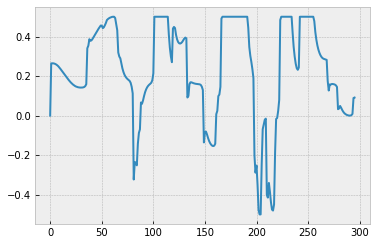

In [48]:
plt.plot(u_full[1])
plt.plot(x_full[1])
plt.plot(x_full_T[1])
plt.plot(x_H_full[1])

In [17]:
print(lap_time, lap_time_H, lap_time_T)

8.52 7.41 8.879999999999999


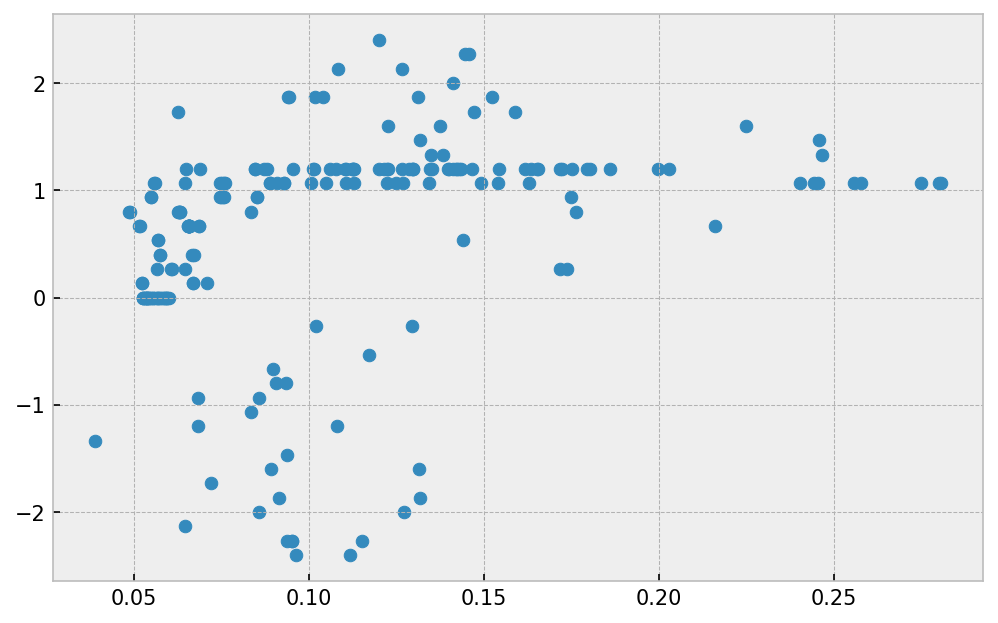

In [28]:
fig, ax = plt.subplots(figsize=(8,5), dpi=150)
ax.scatter(q_p_full[:,0], curv_full.mean(-1))

x_init: -1.528858223313768
y_init: -1.298530464452226
yaw_init: 0.0
Total Arc Length: 16.30667790587336


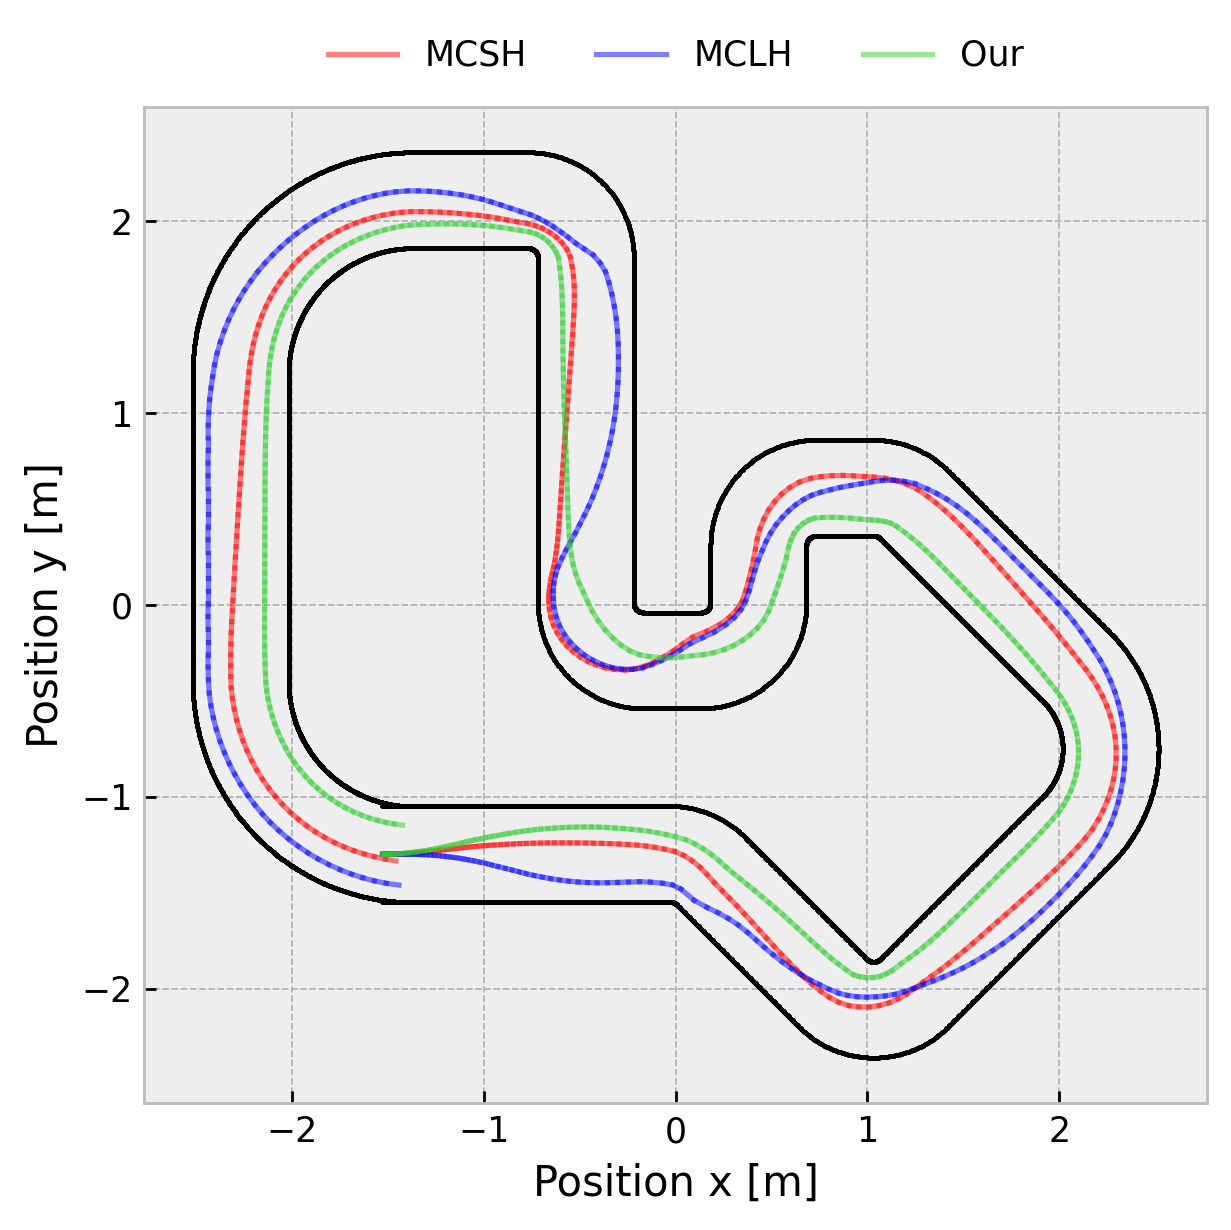

In [16]:
plot_sim_all([x_full_T.T, x_H_full.T, x_full.T])
#plot_sim_all([x_full_T.T, x_H_full.T])

x_init: -1.528858223313768
y_init: -1.298530464452226
yaw_init: 0.0
Total Arc Length: 16.30667790587336


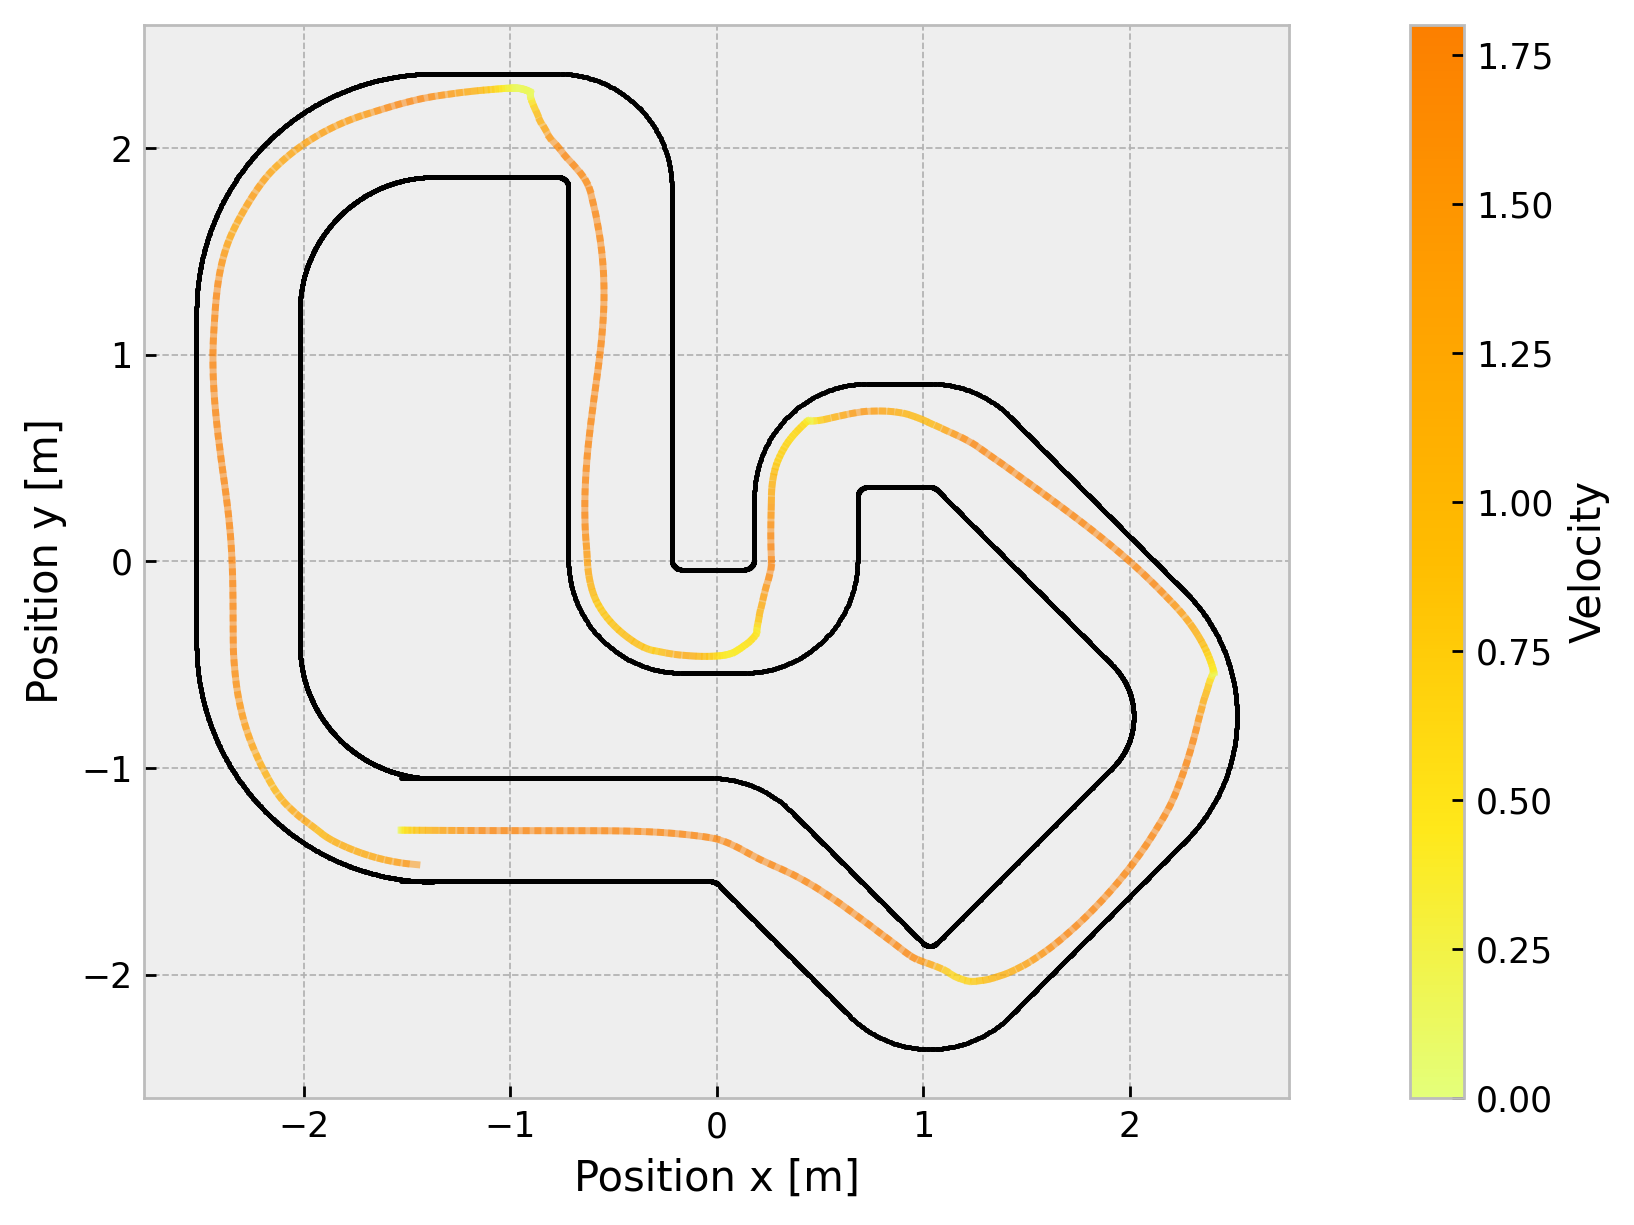

In [14]:
plot_sim(x_full_T.T, u_full_T.T, 4)

x_init: -1.528858223313768
y_init: -1.298530464452226
yaw_init: 0.0
Total Arc Length: 16.30667790587336


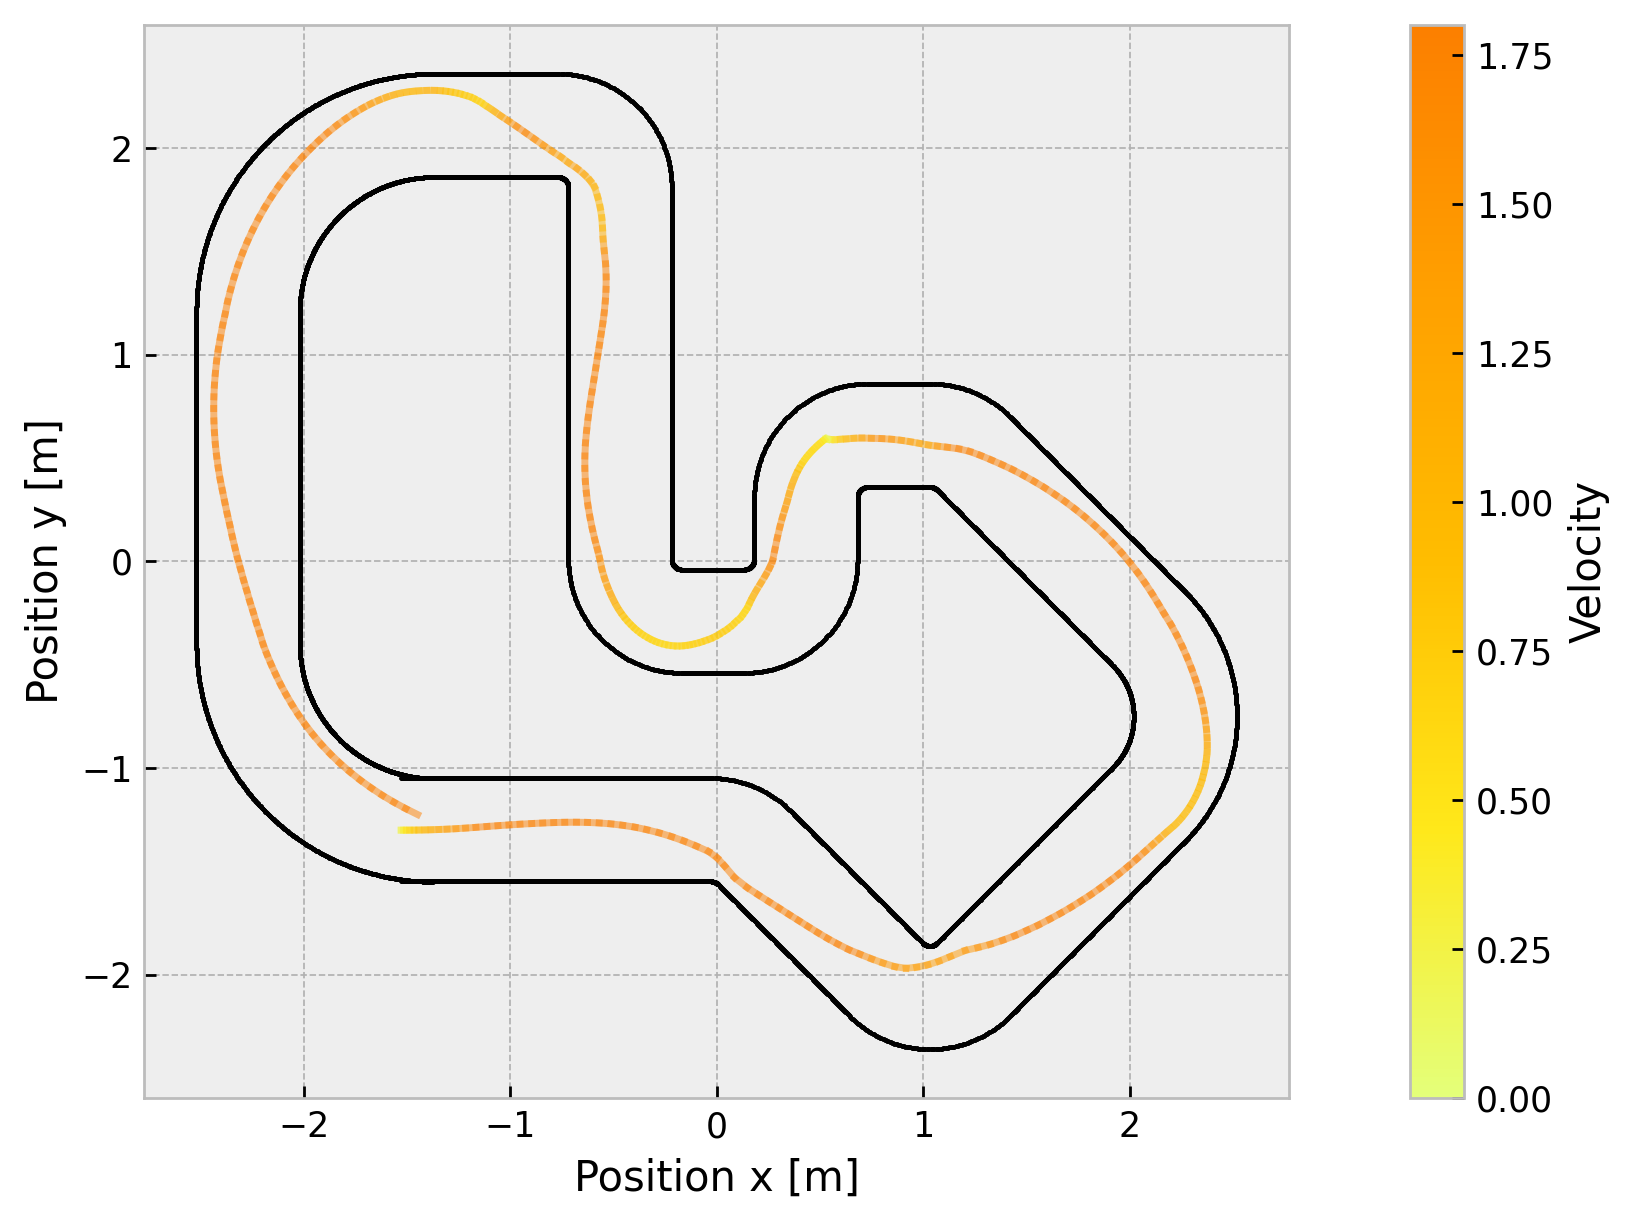

In [15]:
plot_sim(x_H_full.T, u_H_full.T, 4)

In [16]:
lap_time_H, lap_time_T

(10.77, 13.41)

In [20]:
q_lap_np_casadi = np.expand_dims((Q_manual[:,idx_to_casadi].T), 1)
p_lap_np_casadi = np.expand_dims((p_manual[:,idx_to_casadi].T), 1)

In [70]:
x_b_pred, u_b_pred = utils_car.solve_casadi(
            q_lap_np_casadi[:,0,:], p_lap_np_casadi[:,0,:],
            x0_lap_pred, dx, du, control)

In [16]:
x0_lap_pred[1] = 0
x0_lap_pred[2] = 0

In [20]:
xaux.shape

torch.Size([10])

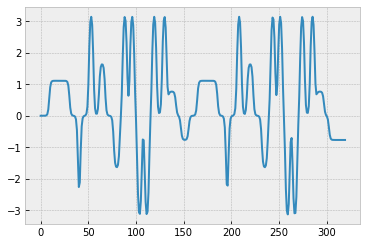

In [12]:
plt.plot(true_dx.curv(torch.arange(0,32,0.1)).numpy())

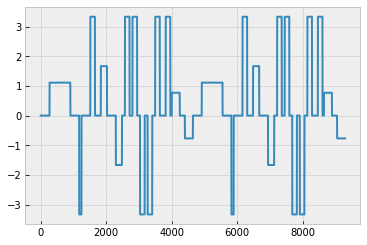

In [11]:
plt.plot(track_coord[-1])

In [26]:
num_sf = self.sigma_f.size()
num_s = sigma.size()

sigma_f_mat = self.sigma_f.repeat(num_s[0],1)

sigma_shifted = sigma.reshape(-1,1) - sigma_f_mat
curv_unscaled = torch.sigmoid(self.smooth_curve*sigma_shifted)
curv = (curv_unscaled@(self.curv_f.reshape(-1,1))).type(torch.float)

curv.reshape(-1)

NameError: name 'self' is not defined

In [19]:
lap_time_H, lap_time_T

(8.28, 8.58)

In [135]:
true_dx.forward(torch.hstack((torch.tensor(x_H_full[:,225]), torch.zeros(4,))), torch.tensor(u_H_full[:,225]))

tensor([[ 1.3707e+01,  9.0612e-02, -2.9608e+00,  2.7477e+00,  1.2186e+01,
         -5.8278e-01,  0.0000e+00,  1.3707e+01,  0.0000e+00,  3.2405e+07]],
       dtype=torch.float64)

In [42]:
torch.tensor(u_H_full[:,260:280])

tensor([[-6.4205e-05,  6.4200e-05,  5.2511e-09, -2.7997e-05,  2.7997e-05,
         -1.7168e-04,  1.7168e-04, -4.8384e-06,  4.8384e-06, -1.0605e-05,
          1.0605e-05, -1.1051e-08,  1.1054e-08, -1.0000e+00,  1.0000e+00,
         -2.9718e-04,  2.9716e-04, -1.0550e-07,  1.2496e-07, -1.4390e-10],
        [ 5.4995e-01,  3.6820e-01,  2.8433e-01,  3.3866e-01,  5.4991e-01,
          5.5000e-01,  5.5000e-01,  5.5000e-01,  5.5000e-01,  5.5000e-01,
          5.5000e-01,  5.5000e-01,  5.5000e-01, -5.5000e-01,  5.5000e-01,
          5.5000e-01,  5.5000e-01,  5.5000e-01,  5.5000e-01,  5.5000e-01]],
       dtype=torch.float64)

In [136]:
torch.hstack((torch.tensor(x_H_full[:,225]), torch.zeros(4,)))

tensor([12.9849,  0.1139, -0.0674,  1.8000, 12.8915,  0.0934,  0.0000,  0.0000,
         0.0000,  0.0000], dtype=torch.float64)

In [128]:
track_coord

torch.Size([5, 9298])

In [126]:
x_H_full[:,225:230]

array([[12.98491141, 13.0856311 , 13.17690938, 13.24352313, 13.31045585],
       [ 0.11388289,  0.11024345,  0.09360397,  0.06725766,  0.17000001],
       [-0.06744869, -0.31323573, -0.50967671, -0.55221811, -0.84104544],
       [ 1.79998854,  1.79999997,  1.79999803,  1.79999997,  1.75499997],
       [12.89153172, 12.98491141, 13.0856311 , 13.17690938, 13.24352313],
       [ 0.09337969,  0.10071968,  0.09127828,  0.06661375,  0.06693272]])

In [127]:
u_H_full[:,224:229]

array([[ 1.14651268e-09, -3.81013478e-04,  3.81021518e-04,
        -6.46077590e-05,  6.46065031e-05],
       [ 5.50000022e-01,  5.49995943e-01,  5.50000022e-01,
         5.49999717e-01,  5.50000022e-01]])

x_init: 0.15000000000000002
y_init: -1.0499999999999994
yaw_init: 0.0
Total Arc Length: 11.568244517641709


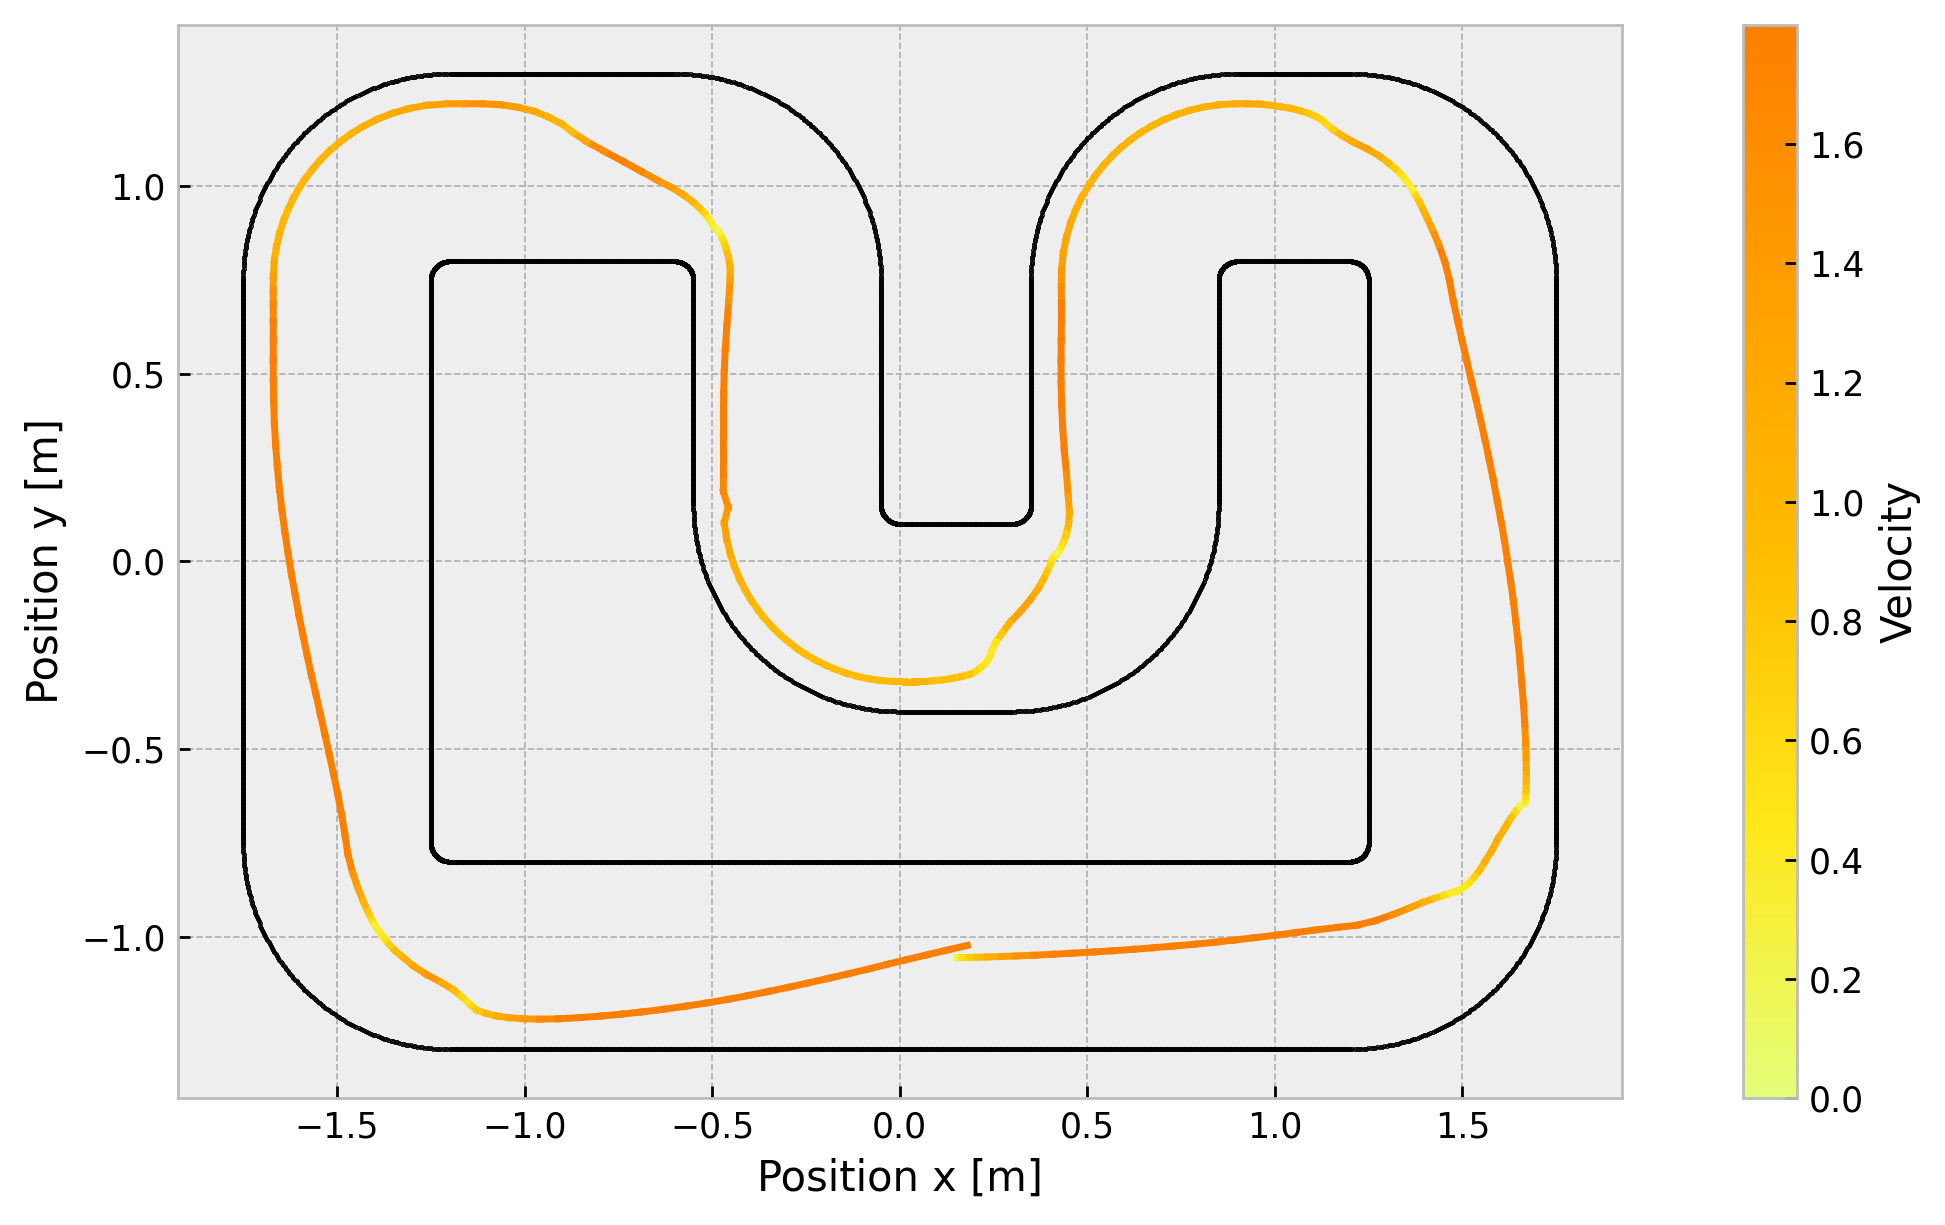

In [18]:
plot_sim(x_full.T)

In [25]:
x_full.shape

(8, 335)

In [24]:
x0_lap_pred[1] + 0.01*torch.randn((1,))

tensor([-0.0089])

In [18]:
from tqdm import tqdm

In [17]:
lap_times = []
for i in tqdm(range(10)):
    x0_s = x0_lap_pred.copy()
    x0_s[1] = x0_s[1] + 0.03*torch.randn((1,))
    x0_s[2] = x0_s[2] + 0.04*torch.randn((1,))
    lap_time, finished, x_full, _, _, _ = eval_lap(x0_s, Q_manual, p_manual, control, model=model)
    lap_times.append(lap_time)

100%|███████████████████████████████████████████████████████████████| 10/10 [07:10<00:00, 43.07s/it]


In [ ]:
lap_times_H = []
for i in tqdm(range(10)):
    x0_s = x0_lap_pred.copy()
    x0_s[1] = x0_s[1] + 0.03*torch.randn((1,))
    x0_s[2] = x0_s[2] + 0.04*torch.randn((1,))
    lap_time_H, finished_H, x_H_full, _, _, _ = eval_lap(x0_s, Q_manual_H, p_manual_H, control_H)
    lap_times_H.append(lap_time_H)

In [16]:
lap_times_T = []
for i in tqdm(range(10)):
    x0_s = x0_lap_pred.copy()
    x0_s[1] = x0_s[1] + 0.03*torch.randn((1,))
    x0_s[2] = x0_s[2] + 0.04*torch.randn((1,))
    lap_time_T, finished_T, x_full_T, _, _, _ = eval_lap(x0_s, Q_manual, p_manual, control)
    lap_times_T.append(lap_time_T)

100%|███████████████████████████████████████████████████████████████| 10/10 [07:04<00:00, 42.46s/it]


In [22]:
print(np.array(lap_times_T).mean(), np.array(lap_times_T).std())

12.978 0.09599999999999953


In [19]:
lap_times

[9.69,
 9.629999999999999,
 9.9,
 9.69,
 9.719999999999999,
 9.69,
 9.629999999999999,
 9.78,
 9.629999999999999,
 7.2299999999999995]

In [21]:
np.array(lap_times)[[0,1,2,3,4,5,6,7,8]].mean()

9.706666666666665

In [33]:
np.array(lap_times_T)[[1,2,3,4,5,6,7,8]].std()

0.09054522350737211

In [32]:
print(np.array(lap_times_H).mean(), np.array(lap_times_H).std())

7.9590000000000005 0.0859592926913664


In [37]:
np.array(lap_times_T)[[0,1,3,4,5,6,9]].std()

0.2906080887113946

In [45]:
print(np.array(lap_times_T).mean(), np.array(lap_times_T).std())

12.978 0.1571496102445059


In [30]:
lap_times_H

[7.859999999999999,
 8.1,
 7.89,
 7.859999999999999,
 8.1,
 7.92,
 8.04,
 7.949999999999999,
 7.92,
 7.949999999999999]

In [34]:
print(np.array(lap_times_T).mean(), np.array(lap_times_T).std())

12.978 0.1571496102445059


In [22]:
np.zeros((5,5))

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [16]:
from time import time

In [26]:
lap_time_results = np.zeros((8,10))
exe_time_results = np.zeros((8,10))

hors = [7, 15, 25, 35, 50]

for j in range(len(hors)):

    mpc_H = hors[j]
    
    params_H = torch.tensor([l_r, l_f, track_width, dt, k_curve, v_max, delta_max, a_max, NL])
    control_H = utils_new.CasadiControl(track_coord, params_H)
    
    Q_manual_H = np.repeat(np.expand_dims(np.array([0, 3.0, 3.0, 0.01, 0.01, 0.01, 0.01, 0.01, 1, 1, 0.01, 3.0]), 0), NL, 0)
    p_manual_H = np.repeat(np.expand_dims(np.array([0, 0, 0, 0, 0, 0, 0, -pc, 0, 0, 0, 0]), 0), NL, 0)

    for i in tqdm(range(10)):
        start = time()
        x0_s = x0_lap_pred.copy()
        x0_s[1] = x0_s[1] + 0.03*torch.randn((1,))
        x0_s[2] = x0_s[2] + 0.04*torch.randn((1,))
        lap_time_H, finished_H, x_H_full, _, _, _ = eval_lap(x0_s, Q_manual_H, p_manual_H, control_H)
        end = time()
        lap_time_results[j, i] = lap_time_H
        exe_time_results[j, i] = end-start

9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:25<00:00, 14.52s/it]


9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:16<00:00, 13.61s/it]


9


100%|████████████████████████████████████████████████████████████████| 10/10 [06:19<00:00, 37.93s/it]


9


100%|████████████████████████████████████████████████████████████████| 10/10 [04:29<00:00, 26.97s/it]


9


100%|████████████████████████████████████████████████████████████████| 10/10 [05:09<00:00, 30.98s/it]


9


100%|████████████████████████████████████████████████████████████████| 10/10 [06:34<00:00, 39.44s/it]


9


100%|████████████████████████████████████████████████████████████████| 10/10 [08:20<00:00, 50.07s/it]


9


100%|████████████████████████████████████████████████████████████████| 10/10 [10:08<00:00, 60.81s/it]


In [36]:
exe_time_results

array([[12.93754673, 13.81738091, 13.83287072, 14.36621451, 15.66337657,
        14.25561404, 15.53403735, 14.30989337, 13.85946441, 16.61719036],
       [15.51765561, 12.86314535, 13.49398685, 13.15835381, 13.29155159,
        13.81120515, 14.13433409, 13.66629934, 13.32538915, 12.81987762],
       [21.50074482, 20.65542507, 78.35657406, 33.16554189, 21.03755927,
        20.62007809, 41.93000269, 20.97730041, 77.03542423, 43.99692559],
       [26.54701829, 26.54679894, 26.64453149, 27.32214379, 26.82715297,
        27.13488984, 26.70936799, 27.0863533 , 27.48548913, 27.37582541],
       [30.78993487, 30.40667033, 30.33028984, 30.86296082, 31.22882271,
        30.90075374, 31.06801438, 31.02376509, 31.588902  , 31.55178857],
       [38.20750713, 37.87983704, 38.3695097 , 40.18755198, 40.22866011,
        39.87684059, 39.85707426, 39.86487389, 39.68224382, 40.22539473],
       [47.26742792, 47.59660983, 47.08968639, 47.73211312, 50.81714082,
        51.17655993, 51.79581881, 52.59144163

In [ ]:
np.quantile(exe_time_results,0.5)

In [39]:
(np.quantile(exe_time_results,0.5,1)/lap_time_results.mean(1))/(np.quantile(exe_time_results,0.5,1)/lap_time_results.mean(1))[0]

array([ 1.        ,  2.04385998,  4.36675341,  4.4356585 ,  5.15753234,
        6.68099654,  8.64640994, 10.34005642])

In [33]:
exe_time_results.std(1)

array([ 1.03816018,  0.74428741, 21.63275998,  0.3387315 ,  0.39698617,
        0.86606574,  2.22762917,  0.5061034 ])

In [25]:
exe_time_results

array([[13.26556158, 12.68358588, 13.01929975, 13.67272663, 14.1879797 ,
        15.68592739, 14.80508184, 15.17413545, 14.68090868, 15.16282606],
       [13.60536933, 13.62759304, 13.50904608, 13.57097006, 13.56243277,
        13.67304182, 13.61436605, 13.48762012, 13.43047166, 13.43516135],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        